In [30]:
import pandas as pd
import numpy as np
import ast
import re
from datetime import datetime
from collections import Counter
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import requests
from bs4 import BeautifulSoup
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()
imp = IterativeImputer(max_iter=10, random_state=42)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\shiri\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


This notebook documents an analysis of Airbnb data. In the analysis, we'll examine the reviews for Airbnb properties and try to figure out which features of properties or their hosts can predict user ratings and the sentiment of user reviews. The data used here are for four U.S. cities, Austin, Boston, Chicago, and Portland, but it can be very easily expanded to other cities and countries available on the Airbnb Get the data page. Similarly, the data selected for the analysis represent four months in 2021 (January, April, July, and September), but it's straightforward to include other months.

The following block of code downloads the data on listings (properties) and user reviews from Airbnb and combines them into two data sets (one with listings, and another one with reviews). This code drops a number of variables that are unhelpful in predictions, that contain a large number of missing values that would be difficult to recover, or that are essentially duplicates of other variables. For example, using host response rate is not going to help us with predictions a lot because for the overwhelming majority of hosts, these rates are very close to 100%, and keeping this variable in the data would require us to drop about 20-25% of the data. Similarly, host response time is within several hours for the overwhelming majority of hosts.

In [31]:
# Get the data
# Scrape URLs to specific Airbnb data sets
reqs = requests.get('http://insideairbnb.com/get-the-data.html')
soup = BeautifulSoup(reqs.text, 'html.parser')
 
data_urls = [link.get('href') for link in soup.find_all('a')]
data_urls = [link for link in data_urls if link is not None]

# Select particular cities
data_urls = [link for link in data_urls if ('tx/austin' in link or 
                                            'ma/boston' in link or
                                            'il/chicago' in link or
                                            'or/portland' in link)]

def check_month(url_full, month_list):
    
    '''Check whether url contains a particular month.'''
    
    date_compiled = re.search(r'\d{4}-\d{2}-\d{2}', url_full).group()
    url_month = datetime.strptime(date_compiled, '%Y-%m-%d').month
    return(url_month in month_list)

# Keep records for January, April, July, and October
data_urls = [link for link in data_urls if check_month(link,
                                                       [1, 4, 7, 10])]

# Split lists of URLs into listings and reviews data
data_urls_prop = [link for link in data_urls if 'listings.csv.gz' in link]
data_urls_rev = [link for link in data_urls if 'reviews.csv.gz' in link]


# Get data for specific cities and dates
def read_airbnb_data(data_url):
    
    '''Read in data from Airbnb for selected cities and dates.'''
    
    adf = pd.read_csv(data_url, index_col=None, header=0)
    
    # Drop variables unlikely to be useful in prediction
    # or with a lot of missing values that are difficult to impute
    if 'listings.csv.gz' in data_url:
        adf = adf.drop(columns = [
            'listing_url', 'scrape_id', 'last_scraped', 'picture_url',
            'host_url', 'host_location', 'host_thumbnail_url', 
            'host_picture_url', 'neighbourhood', 'host_acceptance_rate',
            'host_response_rate', 'host_response_time',
            'neighbourhood_group_cleansed', 'latitude', 'longitude',
            'bathrooms', 'bathrooms_text', 'accommodates', 'property_type',
            'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
            'maximum_minimum_nights', 'minimum_maximum_nights',
            'maximum_maximum_nights', 'minimum_nights_avg_ntm',
            'maximum_nights_avg_ntm', 'calendar_updated', 
            'has_availability', 'availability_30', 'availability_60',
            'availability_90', 'availability_365', 'calendar_last_scraped',
            'license', 'host_verifications', 
            'host_has_profile_pic', 'first_review', 'last_review',
            'host_listings_count', 'calculated_host_listings_count',
            'calculated_host_listings_count_entire_homes',
            'calculated_host_listings_count_private_rooms',
            'calculated_host_listings_count_shared_rooms',
            'reviews_per_month', 'number_of_reviews',
            'number_of_reviews_ltm', 'number_of_reviews_l30d',
            'review_scores_accuracy', 'review_scores_cleanliness',
            'review_scores_checkin', 'review_scores_communication',
            'review_scores_location', 'review_scores_value'
            ], axis=1)
    
    if 'reviews.csv.gz' in data_url:
        adf = adf.drop(columns=['id', 'date', 'reviewer_id', 'reviewer_name'], 
                       axis=1)
        
    data_city = re.split(r'\d{4}-\d{2}-\d{2}', data_url)[0]
    data_city = re.split('/(.*?)/', data_city)[-2].capitalize()
    
    data_date = re.search(r'\d{4}-\d{2}-\d{2}', data_url).group()
    
    adf['City'] = data_city
    adf['Date'] = data_date
    adf['Month'] = datetime.strptime(data_date, '%Y-%m-%d').strftime("%B")

    return(adf)

# Read data on listings (properties) and combine in a single data set
prop_df = [read_airbnb_data(link) for link in data_urls_prop]
prop_df = pd.concat(prop_df, axis=0, ignore_index=True)

# Read reviews data and combine in a single data set
reviews_df = [read_airbnb_data(link) for link in data_urls_rev]
reviews_df = pd.concat(reviews_df, axis=0, ignore_index=True)


Now, we will transform and clean up the downloaded data. First, we'll calculate the sentiment scores for user reviews. The analysis here uses the polarity scores based on the VADER lexicon (basically, there is a polarity score for each word in a review, and the sentiment intensity analyzer from VADER creates an aggregated polarity score for each review; larger scores are better). Then, we aggregate polarity scores calculated for each review by Airbnb listing (property), creating an average sentiment score for each listing.

In [32]:
# Calculate sentiment (polarity score) for each review
def get_polarity_score(review_text):
    
    '''Returns polarity scores for words in Airbnb comments.'''
    
    try:
        review_polarity = sia.polarity_scores(review_text)
        return review_polarity['compound']
    except:
        return np.nan
   
reviews_df['rev_sent'] = reviews_df[
    'comments'
    ].apply(get_polarity_score)

# Calculate average sentiment by property
sentiment_by_listing = reviews_df.groupby(
    'listing_id'
    ).rev_sent.mean().reset_index()

# Join reviews data with the data on listings
prop_df = pd.merge(
    prop_df, sentiment_by_listing, left_on='id', right_on='listing_id',
    how='left'
    ).drop(columns=['listing_id'])

Then, we transform a number of variables to prepare data for the analysis. First, we create dummy variables for amenities listed for each property. The variable that reports amenities in the original data is simply a list for each property. The code here creates a list of all amenities mentioned in the listings and drops the amenities that are mentioned rarely or almost always (and thus are not very helpful in predicting review scores or sentiment). The list of amenities also needs to be trimmed to avoid overfitting.

In [33]:
# Create dummies for amenities mentioned in listings
# Count the frequency for each amenity
amenities_list = []
for i in range(0, prop_df.shape[0]):
    amenities_list.extend(ast.literal_eval(prop_df.amenities[i]))
amenities_count = Counter(amenities_list)

# Keep amenities that are not mentioned too rarely or too frequently
amenities_frequent = dict()
for (key, value) in amenities_count.items():
   if value > 10000 and value < 80000 and not ('TV' in key):
       amenities_frequent[key] = value

for amenity in list(amenities_frequent.keys()):
    amenity_name = "am_" + amenity.lower()
    amenity_name = amenity_name.replace(" ", "_").replace("-", "_")
    prop_df[amenity_name] = prop_df.amenities.str.contains(amenity).astype(int)


Next, we create dummies for a number of variables, including room types, cities, months, and several host features. For the most part, this is straightforward. Worth noting is the dummy for many listings: instead of including the total number of properties for each host, we create a dummy for hosts with more than 3 properties. Such hosts are probably those who do this on a professional basis rather than just renting out a couple of apartments they have. Such recoding also deals with outliers.  

In [34]:
# Convert variables into dummies
prop_df['host_identity_verified'] = (prop_df[
    'host_identity_verified'
    ] == 't').astype(int)
prop_df['instant_bookable'] = (prop_df[
    'instant_bookable'
    ] == 't').astype(int)
prop_df['host_is_superhost'] = (prop_df[
    'host_is_superhost'
    ] == 't').astype(int)

# Add dummy for whether host neighborhood is indicated
prop_df['host_neigh_present'] = prop_df[
    'host_neighbourhood'
    ].isnull().astype(int)
    
# Create dummies for room types
prop_df = pd.get_dummies(prop_df, columns=['room_type'], 
                         prefix='room_type')

# Create a dummy that captures whether a host has more than 
# 3 properties listed
prop_df['host_many_listings'] = (prop_df['host_total_listings_count'] 
                                 > 3).astype(int)

# Create dummies for city and month
prop_df = pd.get_dummies(prop_df, columns=['City'], prefix='city')
prop_df = pd.get_dummies(prop_df, columns=['Month'], prefix='month')


Next, we create or recode several numeric variables. Price is a string variable in the original data, so we just recode it to numeric. A new variable host_since_days is the number of days one has been a host. We also add variables that capture the length of provided descriptions for the property (listing), for the neighborhood, and for the host (longer descriptions mean more details).

In [35]:
# Recode price as numeric
prop_df['price'] = prop_df['price'].str.replace("\$", "")
prop_df['price'] = pd.to_numeric(prop_df['price'], errors='coerce')

# Recode host_since into days
prop_df['host_since_days'] = pd.to_datetime(prop_df['host_since'])
prop_df['host_since_days'] = (pd.to_datetime('2021-10-20') 
                              - prop_df['host_since_days']).dt.days

# Add property, neighborhood, and host description lengths
prop_df['desc_length'] = prop_df['description'].str.len().fillna(0)
prop_df['neigh_desc_length'] = prop_df[
    'neighborhood_overview'
    ].str.len().fillna(0)
prop_df['host_desc_length'] = prop_df['host_about'].str.len().fillna(0)

C:\Users\shiri\AppData\Local\Temp/ipykernel_25976/1427138003.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  prop_df['price'] = prop_df['price'].str.replace("\$", "")


The next step is to deal with missing data. First, let's check the proportion of missing values for all the variables in the data. 

In [36]:
with pd.option_context('display.max_rows', None):
    print((prop_df.isnull().sum()/prop_df.shape[0]).sort_values(ascending=False))

host_about                         0.342599
neighborhood_overview              0.312408
review_scores_rating               0.213191
rev_sent                           0.184366
host_neighbourhood                 0.128338
bedrooms                           0.090213
price                              0.021547
beds                               0.016314
description                        0.011727
host_since_days                    0.007479
host_total_listings_count          0.007479
host_since                         0.007479
host_name                          0.007479
am_room_darkening_shades           0.000000
am_pool                            0.000000
am_gym                             0.000000
am_conditioner                     0.000000
am_elevator                        0.000000
am_shower_gel                      0.000000
am_baking_sheet                    0.000000
id                                 0.000000
am_carbon_monoxide_alarm           0.000000
am_indoor_fireplace             

Some variables with a lot of missing values were dropped earlier for reasons explained above (and imputing missing values, for example, for host response rate is non-trivial because the pattern of missingness here most likely is non-random, so substituting, say, column means here would bias the results). There are also several variables for which very few values are missing, and it is easier to just drop these rows from the data. I am also dropping rows where the two outcomes of interest, the average user rating and the average sentiment score, are not available, as there is nothing to predict. In addition, I create dummy variables for whether the host has included a description of the neighborhood or a mention of their own neighborhood; this may indicate the effort they've put into describing the property.

That leaves essentially three important variables where there is a substantial number of missing values: the number of beds, the number of bedrooms, and price. Note that these variables are correlated (larger apartments or houses are more expensive), which allows us to do a multiple imputation here, using these variables to predict one another's missing values. For this, we will use iterative multiple imputation from scikit-learn (see [here](https://scikit-learn.org/stable/modules/impute.html) for details). Then, we simply drop the rows with missing values for the remaining variables.

In [37]:
# Replace nans by zeros for bedrooms 
prop_df['bedrooms'] = prop_df['bedrooms'].fillna(0)

# Impute beds and price (strongly correlated)
imp.fit(prop_df[['beds', 'bedrooms', 'price']])
prop_df_imp = imp.transform(prop_df[['beds', 'bedrooms', 'price']])
prop_df_imp = pd.DataFrame(prop_df_imp, columns = ['beds', 'bedrooms', 
                                                   'price'])

# Round imputed beds and bedrooms
prop_df_imp[['beds', 'bedrooms']] = prop_df_imp[['beds', 'bedrooms']].round(0)
prop_df[['beds', 'bedrooms', 'price']] = prop_df_imp[['beds', 'bedrooms', 
                                                      'price']]

# Drop rows with missing values
prop_df = prop_df.dropna(subset=['review_scores_rating', 'rev_sent',
                                 'host_name', 'host_since', 
                                 'host_total_listings_count',
                                 'host_identity_verified'])
prop_df = prop_df[prop_df.price != 0].reset_index(drop=True)


The final bit of cleanup is standardizing column names and recoding the review scores; in some months, the scores are on a 1-100 scale, and in others, they are on a 1-5 scale. We make all scores to be on the 1-5 scale.

In [38]:
# Clean up column names
prop_df.columns = prop_df.columns.str.lower()
prop_df.columns = prop_df.columns.str.replace(' ', '_')
prop_df.columns = prop_df.columns.str.replace('\/', "_")

# Put review scores on the same scale
prop_df['review_scores_rating'] = np.where((prop_df['month_january'] == 1) | 
                                           (prop_df['month_april'] == 1),
                                           prop_df['review_scores_rating'] / 20, 
                                           prop_df['review_scores_rating'])

C:\Users\shiri\AppData\Local\Temp/ipykernel_25976/1394856183.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  prop_df.columns = prop_df.columns.str.replace('\/', "_")


Now, we are ready for the analysis. The next block of code sets up a function to run regression models. The function instantiates the model, creates the training set and the test set, fits the model, and returns the coefficients and other parameters of interest. In this analysis, we will use lasso regression with 10-fold cross-validation that determines the optimal alpha parameter (penalty). The model is trained on a subsample of data (70%) and then validated using a test sample.

And to reiterate, we'll be looking at two outcome variables. The first is the average user rating for each Airbnb property (users assign between 1 and 5 stars for their stay). There are other ratings, e.g., for cleanliness, but we'll consider just the overall rating. The second variable is the average sentiment in user reviews for a given apartment or home. As described above, this is calculated as the average of polarity scores for each user review.

As for predictors, we'll include several host features and a series of variables that describe the listings and the amenities available to guests. Some of the predictors are continuous, but most are dummy variables. All the predictors are normalized before fitting the model.

In [39]:
# Function to run a lasso regression and return coefficients
def run_lasso(y_var, city='all', month='all', show_r2_alpha=True):
    
    '''
    Creates a matrix of predictors and the outcome variable for a given city
    or month, then runs a lasso regression on this set of predictors
    and returns the alpha value, R^2, and model coefficients.
    '''
    
    
    # Set up X and y
    y = prop_df[y_var]
    X = prop_df[predictor_list]
    if city != 'all':
        city_dummy = 'city_' + city
        y = y[prop_df[city_dummy] == 1]
        X = X[X[city_dummy] == 1]
        X = X.loc[:, ~X.columns.str.startswith('city')]
    if month != 'all':
        month_dummy = 'month_' + month
        y = y[prop_df[month_dummy] == 1]
        X = X[prop_df[month_dummy] == 1]
        X = X.loc[:, ~X.columns.str.startswith('month')]
    if city == 'all':
       X = X.drop(columns=['city_portland'])
    if month == 'all':
       X = X.drop(columns=['month_january'])
                
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, 
                                                        random_state=42)
    
    # Instantiate the model, normalizing the predictors
    lm_model = make_pipeline(StandardScaler(with_mean=False), 
                             LassoCV(cv=10, random_state=42))
    
    # Run the model
    lm_model.fit(X, y)
    
    # Predictions for the test set
    y_test_preds = lm_model.predict(X_test)
    
    # Extract model coefficients
    lasso_coefs = pd.DataFrame(
        {'feature': list(X.columns),
         'coef': lm_model.named_steps['lassocv'].coef_
        }, index=list(X.columns))
    lasso_coefs = pd.merge(
        lasso_coefs, predictor_labels, left_on='feature', 
        right_on='predictor_name',
        how='left'
        ).drop(columns=['predictor_name'])
    
    if show_r2_alpha:        
        # R^2 for the test set
        r2_test = r2_score(y_test, y_test_preds)
        
        # Extract optimal alpha suggested by cross-validation
        lasso_alpha = lm_model.named_steps['lassocv'].alpha_
        
        return(lasso_alpha, r2_test, lasso_coefs)
    
    else:        
        return(lasso_coefs)

# List of predictors
predictor_list = ['host_is_superhost', 'host_identity_verified', 'bedrooms',
                  'beds', 'price', 'instant_bookable', 
                  'am_free_street_parking', 'am_patio_or_balcony', 
                  'am_lockbox', 'am_extra_pillows_and_blankets',
                  'am_refrigerator', 'am_hair_dryer',
                  'am_security_cameras_on_property', 'am_cooking_basics', 
                  'am_luggage_dropoff_allowed', 'am_coffee_maker', 
                  'am_bed_linens', 'am_first_aid_kit', 'am_oven', 
                  'am_backyard', 'am_freezer', 'am_microwave',
                  'am_long_term_stays_allowed', 'am_shampoo', 'am_body_soap',
                  'am_bathtub', 'am_free_parking_on_premises', 'am_hangers',
                  'am_dishes_and_silverware', 'am_private_entrance', 
                  'am_hot_water', 'am_stove', 'am_dishwasher', 
                  'am_dedicated_workspace', 'am_iron', 
                  'am_lock_on_bedroom_door', 'am_carbon_monoxide_alarm', 
                  'am_dryer', 'am_washer', 'am_keypad', 'am_indoor_fireplace', 
                  'am_fire_extinguisher', 'am_room_darkening_shades', 
                  'am_shower_gel', 'am_conditioner', 
                  'am_baking_sheet', 'am_pool', 'am_gym', 'am_elevator', 
                  'am_bbq_grill', 'desc_length', 'neigh_desc_length',
                  'host_desc_length', 'host_neigh_present', 'host_since_days',
                  'room_type_entire_home_apt', 'room_type_hotel_room',
                  'room_type_private_room', 'host_many_listings', 
                  'city_austin', 'city_boston', 
                  'city_chicago', 'city_portland',
                  'month_january', 'month_april', 
                  'month_july', 'month_october']


# Clean up predictor names for plots
# Function to clean up names
def pred_name_clean(pred_name):
    
    '''Returns a more readable label based on variable name.'''
    
    pred_name = pred_name.replace('am_', '')
    pred_name = pred_name.replace('city_', '')
    pred_name = pred_name.replace('month_', '')
    pred_name = pred_name.replace('_', ' ')
    pred_name = pred_name.replace('desc', 'description')
    pred_name = pred_name.replace('neigh', 'neighborhood')
    pred_name = pred_name.replace('neighborhood present',
                                  'neighborhood indicated')
    pred_name = pred_name.replace('since days',
                                  'experience (days)')
    pred_name = pred_name.replace('many listings', 'has many listings')
    pred_name = pred_name.replace('home apt', 'home/apt')
    pred_name = pred_name.replace('room type', 'Room type:')
    pred_name = pred_name.capitalize()
        
    return(pred_name)

# Create a data frame with labels for predictors
predictor_labels = pd.DataFrame({'predictor_name': predictor_list,
                                 'predictor_label': [pred_name_clean(p) for p
                                                     in predictor_list]})

# Categorize predictors into groups for easier display later
pred_conds = [predictor_labels['predictor_name'].str.startswith('am_'), 
              predictor_labels['predictor_name'].str.startswith('city_'),
              predictor_labels['predictor_name'].str.startswith('month_'),
              predictor_labels['predictor_name'].str.startswith('host_'),
              predictor_labels['predictor_name'].isin(['bedrooms', 'beds', 
                                                     'price', 
                                                     'instant_bookable',
                                                     'desc_length', 
                                                     'neigh_desc_length']),
              predictor_labels['predictor_name'].str.startswith('room_type_')]
pred_choices = ['Property amenities', 'City', 'Month', 'Host', 
                'Property features', 'Property features']

predictor_labels['predictor_type'] = np.select(pred_conds, pred_choices)

First, we'll run the model on the full sample of our data. The following lines return the alpha parameter selected by cross-validation, the R-squared on the test set, and a data frame of lasso coefficients with predictor labels for easier plotting.

In [40]:
# Predicting review scores
rating_alpha, rating_r2, rating_coefs = run_lasso('review_scores_rating')

# Predicting sentiment
sent_alpha, sent_r2, sent_coefs = run_lasso('rev_sent')

Here's the alpha selected for the model that predicts the overall user rating and the R-squared for this model. We can see that the model explains about 10 percent of the variation in user ratings, which is not a lot.

In [41]:
print("Alpha: " + str(round(rating_alpha, 6)))
print("R2: " + str(round(rating_r2, 4)))

Alpha: 0.000978
R2: 0.101


And here's the same for the model that predicts user review sentiment. This model has a bit more explanatory power (about 16 percent of the variation), but still it does not explain very much. Clearly, there are other factors besides the ones reflected in the data that are relevant to user scores and reviews, which may include, say, the cleanliness of the apartment or the attitude of the host. 

In [42]:
print("Alpha: " + str(round(sent_alpha, 6)))
print("R2: " + str(round(sent_r2, 4)))

Alpha: 0.000154
R2: 0.1607


Nonetheless, let's see which of the available variables are more helpful in explaining our two outcomes related to user reviews. The following plot shows all the coefficients for both models, sorted by size (for the model of user score ratings). We can see that many variables consistently predict both outcomes. Several such variables are host features: hosts who are superhosts and those with a longer experience as hosts receive better ratings and reviews with more positive sentiment, whereas hosts who have many listings receive less positive response. Property features also matter. More expensive lodgings and properties with more detailed (longer) description receive more positive responses, whereas properties that are instantly bookable and those that allow long-term stay are evaluated less positively. In addition, time of the year and city also matter; properties rented in July and October and those situated in Boston and Chicago are perceived less positively.

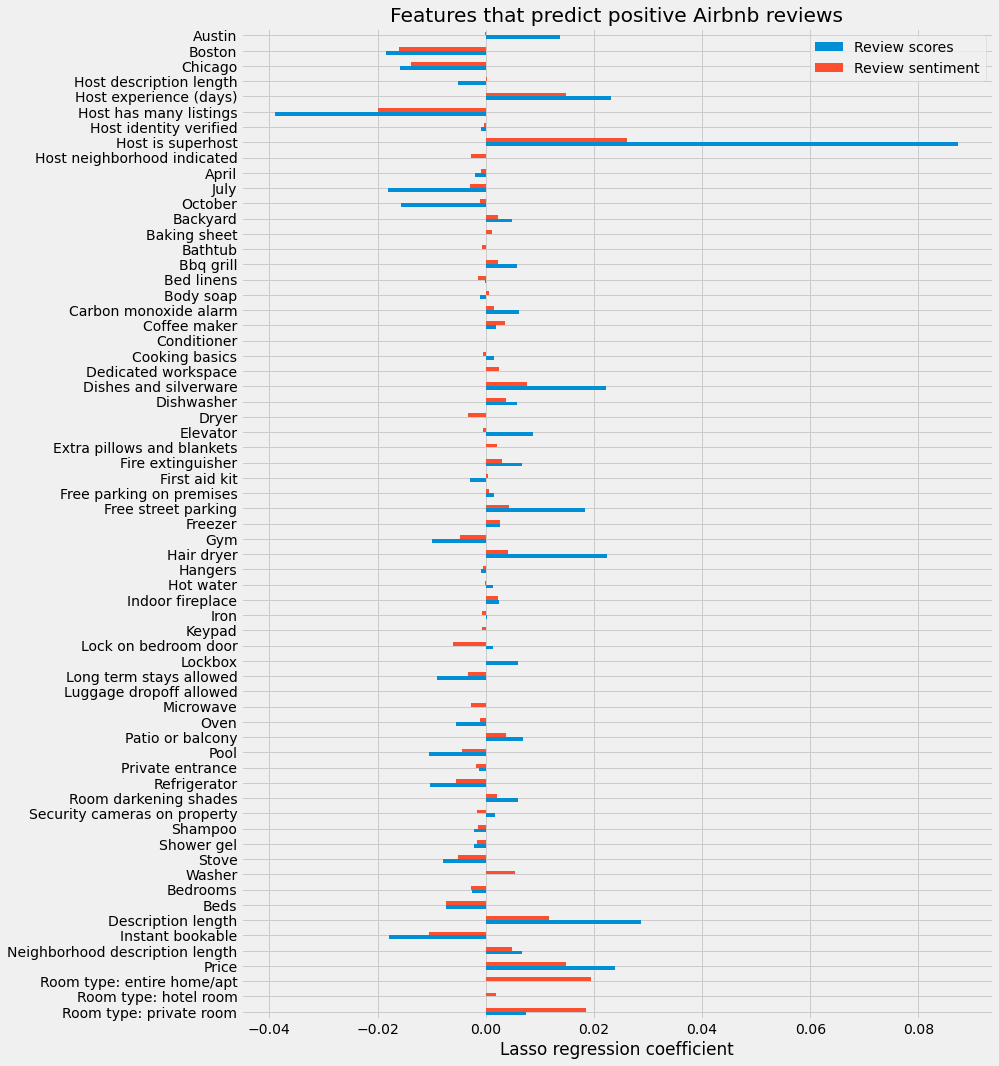

In [43]:
# Merge coefficients from two models and add variable labels
all_coefs = pd.merge(rating_coefs, sent_coefs, 
                     on=['feature',
                         'predictor_label',
                         'predictor_type'],
                     how='left').set_index('predictor_label')
all_coefs = all_coefs.rename(columns={'coef_x': 'review_scores', 
                                      'coef_y': 'sentiment'})
all_coefs = all_coefs.sort_values(by=['predictor_type', 'predictor_label'], ascending=False)

# Plot
plt.style.use('fivethirtyeight')
plot_coefs = all_coefs.plot.barh(figsize=(12,17))
plot_coefs.set(ylabel='', xlabel='Lasso regression coefficient',
               title='Features that predict positive Airbnb reviews')
plt.legend(labels=['Review scores', 'Review sentiment'])

Now, let's see whether the importance of predictors varies across cities. The following runs the same model, but separately on the data for each city.

In [44]:
def run_model_subsample(subsample='city', outcome_var='review_scores_rating'):
    
    '''
    Run the model on a city or month subsample and clean up
    the data frame with coefficients.
    '''
    
    # Run the model on a subsample
    if subsample == 'city':        
        subsample_list = ['austin', 'boston', 'chicago', 'portland']
        coefs_df = [run_lasso(outcome_var, 
                              city=c, 
                              show_r2_alpha=False) for c in subsample_list]
    
    if subsample == 'month':        
        subsample_list = ['january', 'april', 'july', 'october']
        coefs_df = [run_lasso(outcome_var, 
                              month=m, 
                              show_r2_alpha=False) for m in subsample_list]
        
    # Join coefficients for all subsamples and clean up
    subsample_list_cap = [s.capitalize() for s in subsample_list]
    coefs_df = [df.set_index([
            'feature', 'predictor_label', 'predictor_type'
            ]) for df in coefs_df]
    coefs_df = pd.concat(coefs_df, axis=1).reset_index()
    coefs_df = coefs_df.sort_values(by=['predictor_type', 'predictor_label'], ascending=False)
    coefs_df.columns.values[[3, 4, 5, 6]] = subsample_list_cap
    coefs_df = coefs_df.set_index('predictor_label')
    
    return(coefs_df)

rating_coefs_by_city = run_model_subsample()
sent_coefs_by_city = run_model_subsample(outcome_var='rev_sent')
rating_coefs_by_month = run_model_subsample('month')
sent_coefs_by_month = run_model_subsample('month', outcome_var='rev_sent')


Putting everything on one plot might make things confusing, so we're splitting the predictors into three groups (host-related, general property features, and amenities), and there is a separate plot for each group of variables. We can see that some features are consistently associated with higher ratings (being a superhost, having a longer experience as a host, price, hot water, patio, free street parking) or lower ratings (hosts who have many listings, apartment being instantly bookable, long term stays allowed). The contribution of other features (especially various amenities), however, differs across cities. This makes sense given the differences in climate or the urban environment between cities.

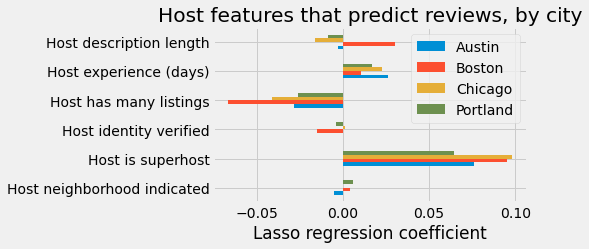

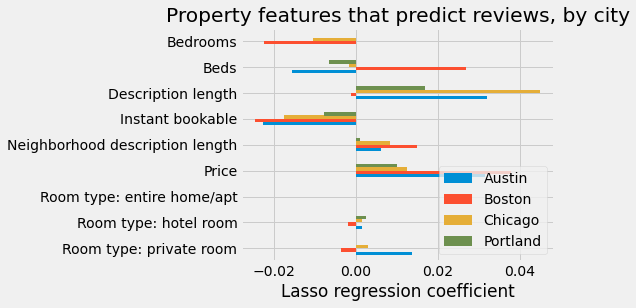

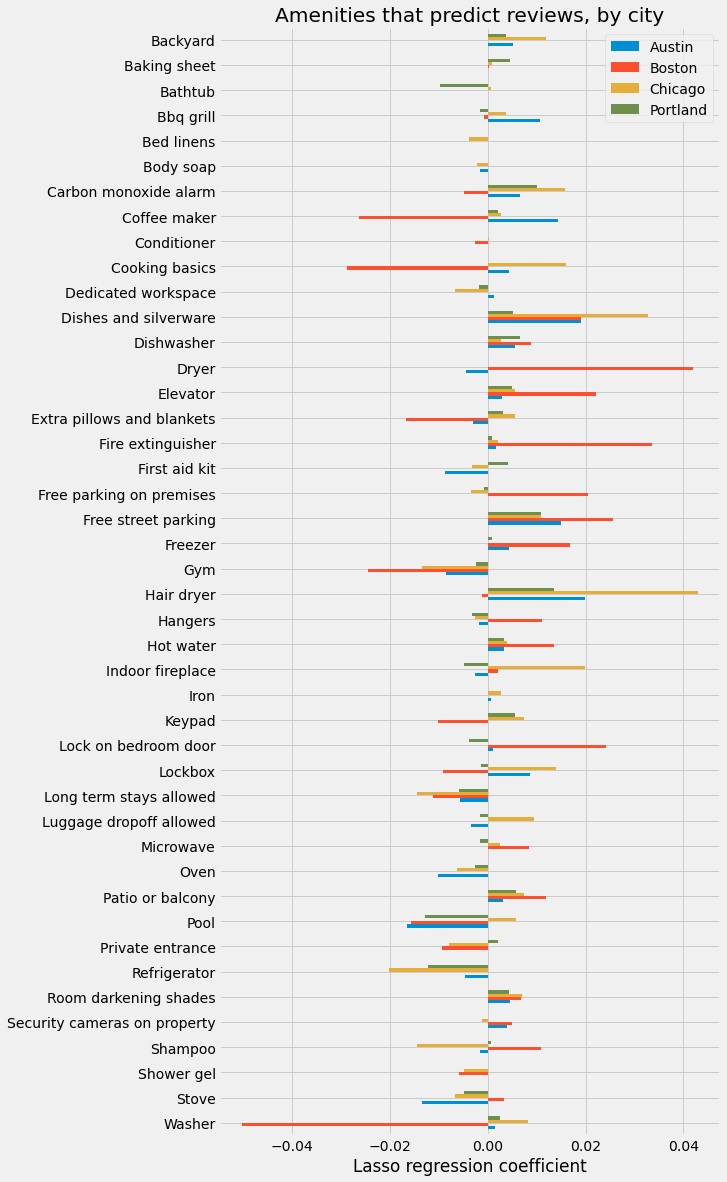

In [45]:
def barplot_subsample(coef_df, predictor_type, plot_title):
    
    '''Plot model coefficients by city or month on the same plot.'''
    
    coef_df_cat = coef_df[coef_df['predictor_type'] == predictor_type]
    
    if predictor_type == 'Host':
        figure_size = [5, 3]
    if predictor_type == 'Property features':
        figure_size = [5, 4]
    if predictor_type == 'Property amenities':
        figure_size = [8, 19]
    
    plot_coefs = coef_df_cat.plot.barh(figsize=figure_size)
    plot_coefs.set(
        ylabel='', xlabel='Lasso regression coefficient',
        title=plot_title)
        
barplot_subsample(rating_coefs_by_city, 'Host', 
                  'Host features that predict reviews, by city')
barplot_subsample(rating_coefs_by_city, 'Property features', 
                  'Property features that predict reviews, by city')
barplot_subsample(rating_coefs_by_city, 'Property amenities', 
                  'Amenities that predict reviews, by city')


The following does the same for predictors of review sentiment, and the results are largely similar.

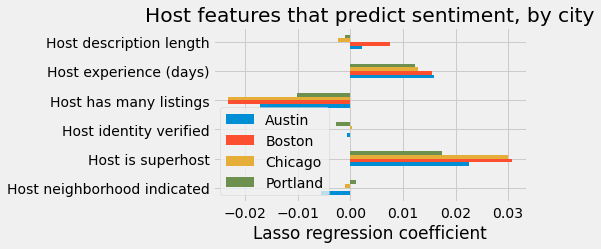

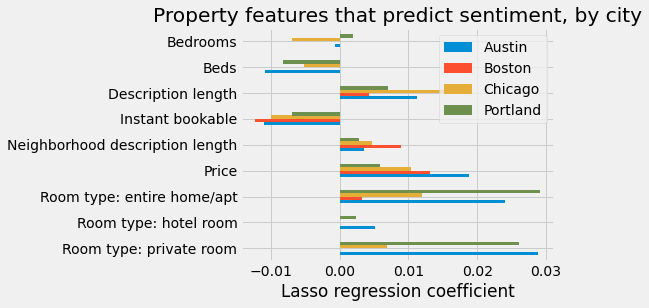

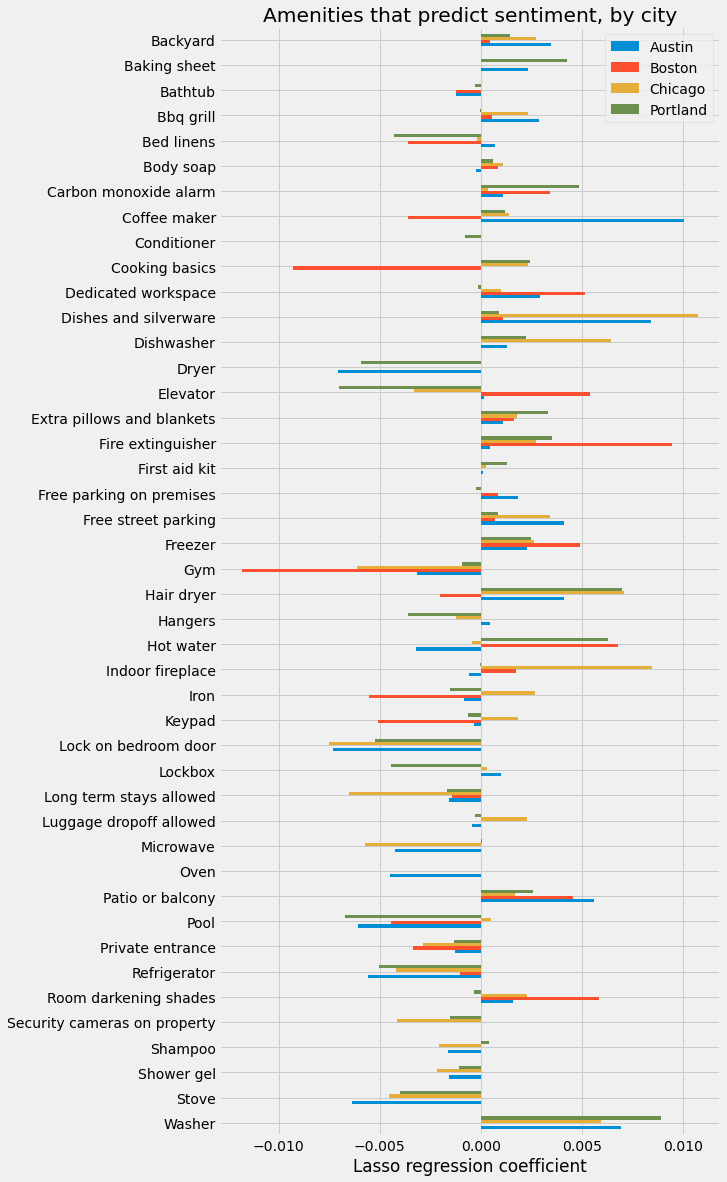

In [46]:
barplot_subsample(sent_coefs_by_city, 'Host', 
                  'Host features that predict sentiment, by city')
barplot_subsample(sent_coefs_by_city, 'Property features', 
                  'Property features that predict sentiment, by city')
barplot_subsample(sent_coefs_by_city, 'Property amenities', 
                  'Amenities that predict sentiment, by city')

Now let's do the same as above, but instead of splitting the data by cities, we'll split it by month (there are four months currently in the data). First, here are the results for rating scores. Here, there is more consistence across different times of the year than it was across different cities, especially with respect to different amenities, but the impact of most variables still somewhat varies by month.

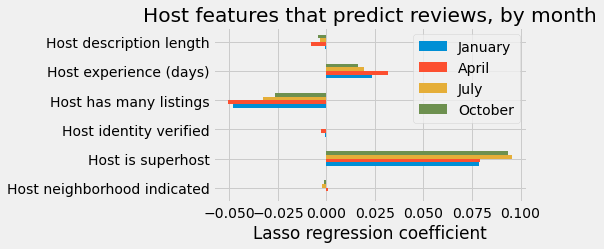

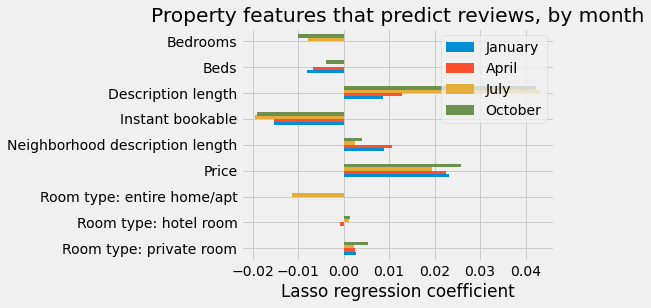

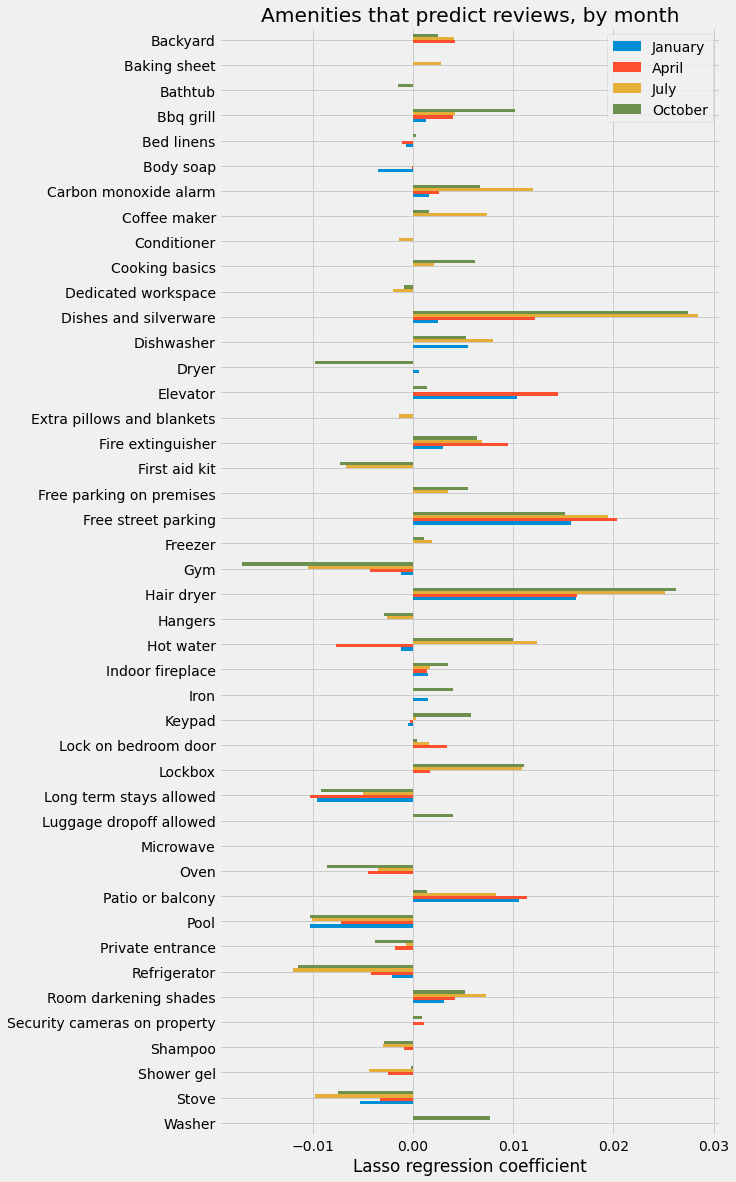

In [47]:
barplot_subsample(rating_coefs_by_month, 'Host', 
                  'Host features that predict reviews, by month')
barplot_subsample(rating_coefs_by_month, 'Property features', 
                  'Property features that predict reviews, by month')
barplot_subsample(rating_coefs_by_month, 'Property amenities', 
                  'Amenities that predict reviews, by month')


And then the same split by month, but for review sentiment. Again, there is a lot of consistency across months.

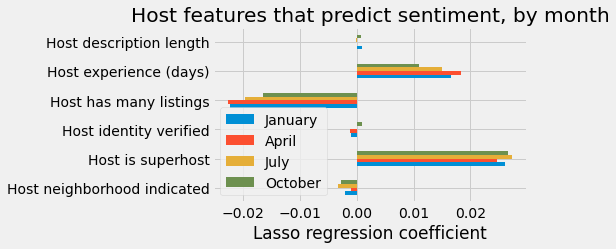

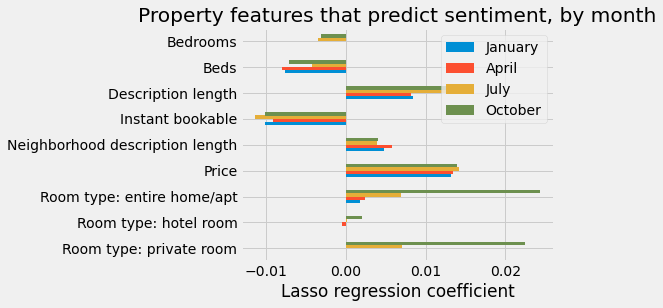

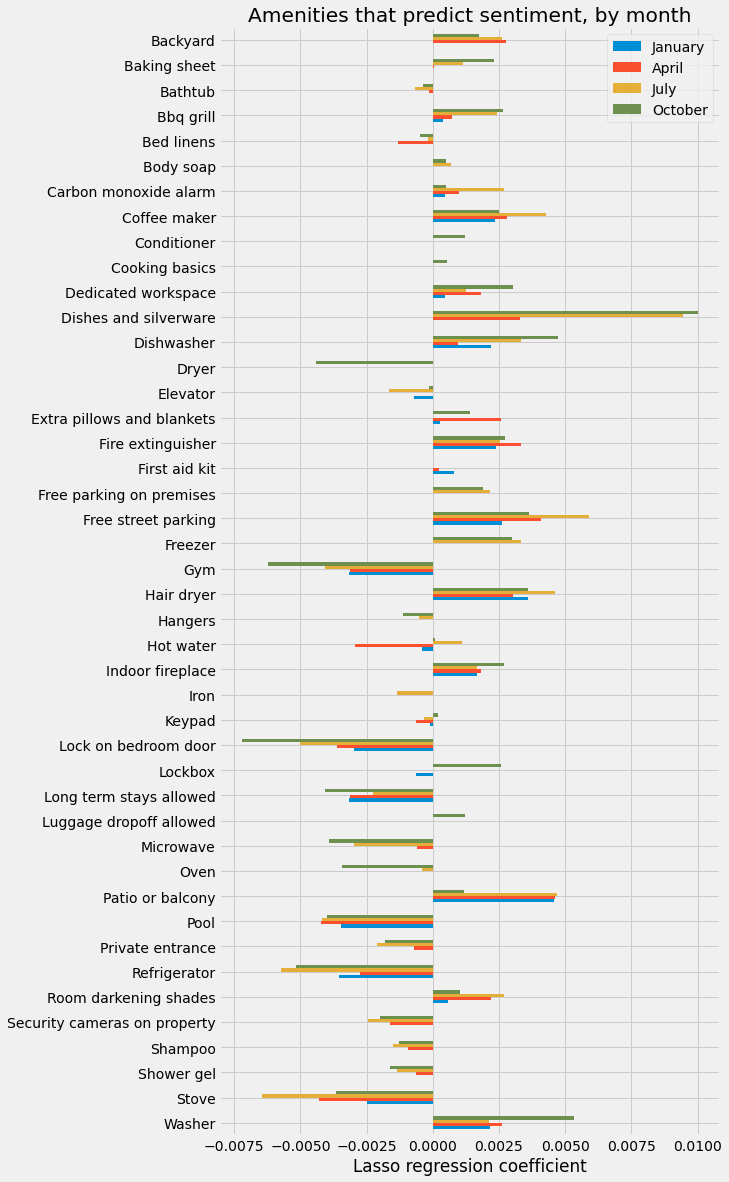

In [48]:
barplot_subsample(sent_coefs_by_month, 'Host', 
                  'Host features that predict sentiment, by month')
barplot_subsample(sent_coefs_by_month, 'Property features', 
                  'Property features that predict sentiment, by month')
barplot_subsample(sent_coefs_by_month, 'Property amenities', 
                  'Amenities that predict sentiment, by month')
